In [ ]:
from google.colab import drive
%load_ext google.colab.data_table
ps_cl_repo_path = 'train361/'
content_path = f'/content/drive/MyDrive/{ps_cl_repo_path}'
data_path = './data/'
drive.mount('/content/drive/')

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Import packages
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Transformations
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandomCrop(128),
            transforms.RandomRotation(180),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )

# Path to data
train_path = '/content/drive/MyDrive/train361'
test_path = '/content/drive/MyDrive/test-361'

# Get data
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Split into training and validation
test_n = len(test_dataset)
val_set, test_set = torch.utils.data.random_split(test_dataset, [int(test_n/2), test_n - int(test_n/2)])

print(len(train_dataset), len(val_set), len(test_set))

# Set batch size
batch_size = 60

# Load and shuffle data and split into batch sizes
loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

240 30 30


In [ ]:
unnormalise = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    x = unnormalise(x)
    x = x.view(x.size(0), 3, 128, 128)
    return x
def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

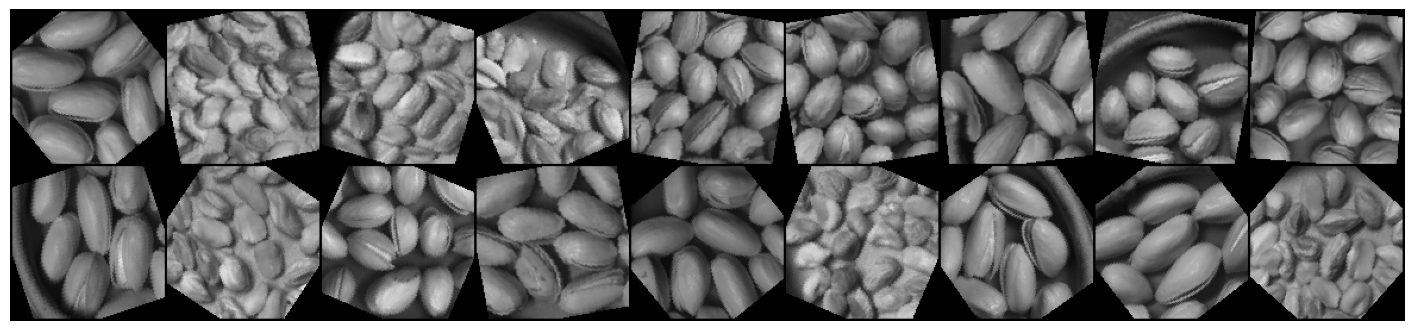

In [ ]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:18, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(18,10))
plt.axis('off')
show(img)

In [ ]:
# ResNet Block as described in paper
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock, self).__init__()

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))

        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

        out = self.left(x)

        out += self.shortcut(x)

        out = F.relu(out)

        return out


# ResNet structure as described in paper
class ResNet(nn.Module):

    def __init__(self, ResidualBlock, num_classes = 29):

        super(ResNet, self).__init__()

        self.inchannel = 16
        self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU())

        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(256, num_classes)


    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []

        for stride in strides:

            layers.append(block(self.inchannel, channels, stride))

            self.inchannel = channels

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def MyResNet():
    return ResNet(ResidualBlock)

In [ ]:
def confusion(preds, y):
  labels = ['L8', 'G160', 'G300']
  # Plot the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax);

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['L8', 'G160', 'G300']
  # Show incorrectly classified images
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None,
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [ ]:
USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)


print_every = 10
def check_accuracy(loader, model, analysis=False):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)


#Training loop
def train_part(model, optimiser, epochs=2):
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        check_accuracy(loader_val, model)


cpu


Total number of parameters is: 2807629
Epoch: 0, Iteration 0, loss = 5.9246
Got 10 / 30 correct of val set (33.33)
Epoch: 1, Iteration 0, loss = 1.1056
Got 10 / 30 correct of val set (33.33)
Epoch: 2, Iteration 0, loss = 0.4561
Got 10 / 30 correct of val set (33.33)
Epoch: 3, Iteration 0, loss = 0.4915
Got 12 / 30 correct of val set (40.00)
Epoch: 4, Iteration 0, loss = 0.4499
Got 11 / 30 correct of val set (36.67)
Epoch: 5, Iteration 0, loss = 0.6403
Got 18 / 30 correct of val set (60.00)
Epoch: 6, Iteration 0, loss = 0.4917
Got 26 / 30 correct of val set (86.67)
Epoch: 7, Iteration 0, loss = 0.5015
Got 21 / 30 correct of val set (70.00)
Epoch: 8, Iteration 0, loss = 0.4943
Got 26 / 30 correct of val set (86.67)
Epoch: 9, Iteration 0, loss = 0.4834
Got 25 / 30 correct of val set (83.33)
Epoch: 10, Iteration 0, loss = 0.4249
Got 28 / 30 correct of val set (93.33)
Epoch: 11, Iteration 0, loss = 0.3547
Got 27 / 30 correct of val set (90.00)
Epoch: 12, Iteration 0, loss = 0.3417
Got 26 / 

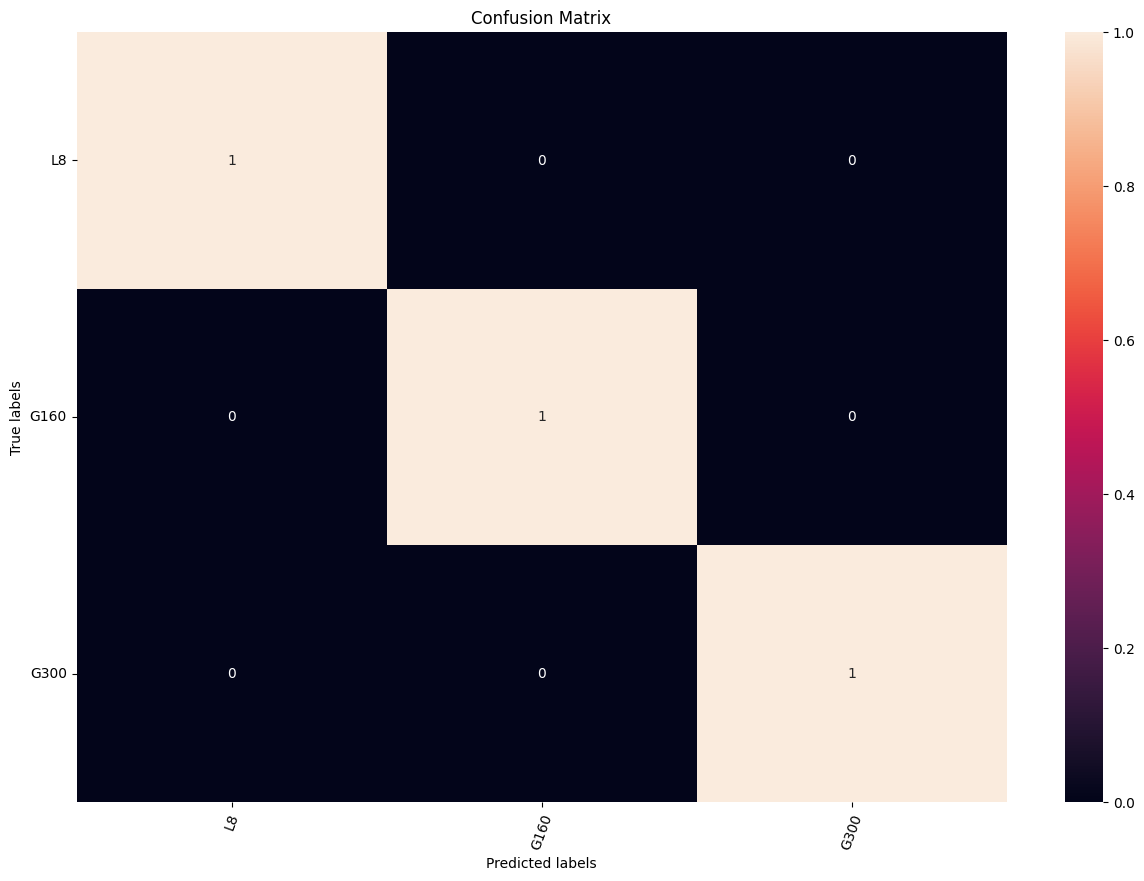

ZeroDivisionError: float division by zero

In [ ]:
# Trains the network
model = MyResNet()
optimiser = optim.Adamax(model.parameters(), lr=0.01, weight_decay=0.001)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimiser, epochs = 50)


# Check Validation Accuracy
check_accuracy(loader_val, model, analysis=True)

# Saves the model
torch.save(model.state_dict(), 'modelpist361.pt')

Got 29 / 30 correct of val set (96.67)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


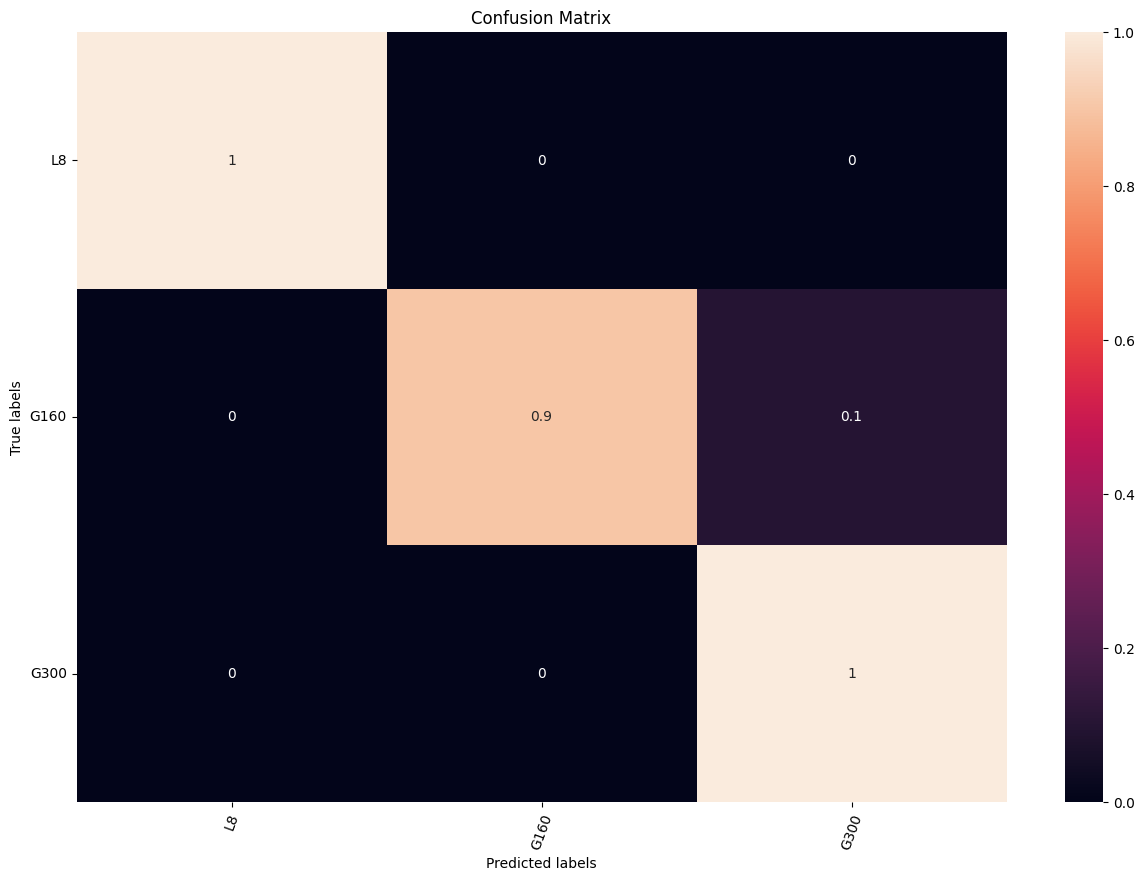

Predicted label ['G300']
True label ['G160']
Corresponding images are shown below


0.9666666666666667

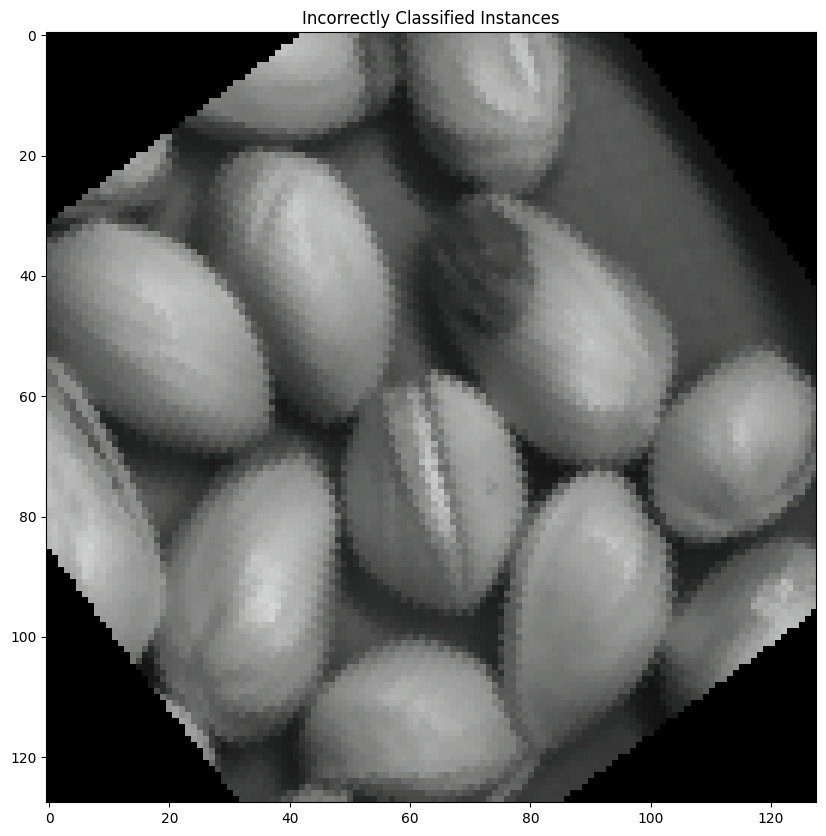

In [ ]:
# Checks test accuracy
check_accuracy(loader_test, model, analysis=True)